In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from copy import deepcopy
from tools.utils import *
from tools.hom_networks import *

In [8]:
def find_learning_rate(model, optimizer, criterion, dataloader, 
                      start_lr=1e-5, end_lr=1e-2, num_iter=100, 
                      smooth_coef=0.05, device=None):
    """
    Learning rate finder inspired by Fast.ai's lr_find
    
    Args:
        model: PyTorch model
        optimizer: Initialized optimizer
        criterion: Loss function
        dataloader: Training dataloader
        start_lr: Starting learning rate
        end_lr: Maximum learning rate to test
        num_iter: Number of iterations to run
        smooth_coef: Loss smoothing coefficient (0-1)
        device: Device to use (default: model's device)
    
    Returns:
        lrs: List of learning rates tested
        losses: List of smoothed losses
    """
    # Save original model and optimizer states
    orig_model = deepcopy(model.state_dict())
    orig_optimizer = deepcopy(optimizer.state_dict())
    
    # Device setup
    device = device or next(model.parameters()).device
    model.to(device)
    
    # Initialize learning rate
    lr = start_lr
    factor = (end_lr / start_lr) ** (1 / num_iter)
    
    # Set up optimizer with initial LR
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    
    losses = []
    lrs = []
    best_loss = None
    iterator = iter(dataloader)
    
    model.train()
    for iteration in range(num_iter):
        try:
            batch = next(iterator)
        except StopIteration:
            iterator = iter(dataloader)
            batch = next(iterator)
        
        # Move data to device
        batch = batch.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(outputs, batch.y) 
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Smooth loss and track
        current_loss = loss.item()
        if best_loss is None:
            best_loss = current_loss
        else:
            current_loss = smooth_coef * current_loss + (1 - smooth_coef) * best_loss
            best_loss = current_loss
        
        losses.append(current_loss)
        lrs.append(lr)
        
        # Update learning rate
        lr *= factor
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        
        # Early stopping if loss explodes
        if current_loss > 4 * best_loss or np.isnan(current_loss):
            break
    
    # Restore original model/optimizer state
    model.load_state_dict(orig_model)
    optimizer.load_state_dict(orig_optimizer)
    
    return lrs, losses

def plot_lr_find(lrs, losses, skip_begin=10, skip_end=5):
    """
    Plot learning rate finder results and suggest optimal LR
    
    Args:
        lrs: List of learning rates
        losses: List of losses
        skip_begin: Number of initial points to skip
        skip_end: Number of final points to skip
    """
    # Calculate gradients
    gradients = np.gradient(losses)
    
    # Find minimum gradient (steepest negative slope)
    min_grad_idx = np.argmin(gradients[skip_begin:-skip_end]) + skip_begin
    optimal_lr = lrs[min_grad_idx]
    
    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(lrs, losses)
    plt.xscale('log')
    plt.scatter(optimal_lr, losses[min_grad_idx], c='red', 
                label=f'Suggested LR: {optimal_lr:.2E}')
    plt.xlabel('Learning Rate (log scale)')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    return optimal_lr

In [9]:
def create_edge_index(data):
    data = data.clone()
    if hasattr(data, 'edge_index_union') and data['edge_index_union'] is not None:
        data['edge_index'] = data['edge_index_union']
        data.pop('edge_index_free', None)
        data.pop('edge_index_bound', None)
        data.pop('pos_free', None)
        data.pop('pos_bound', None)
        data.pop('edge_index_union', None)
    return data

hom_dataset = torch.load('data/PSCDB/hom_pscdb_graphs.pt', weights_only=False)
hom_dataset_reindexed = [create_edge_index(hom_data) for hom_data in hom_dataset]
train_loader = get_train_loader(42, hom_dataset_reindexed, 8)

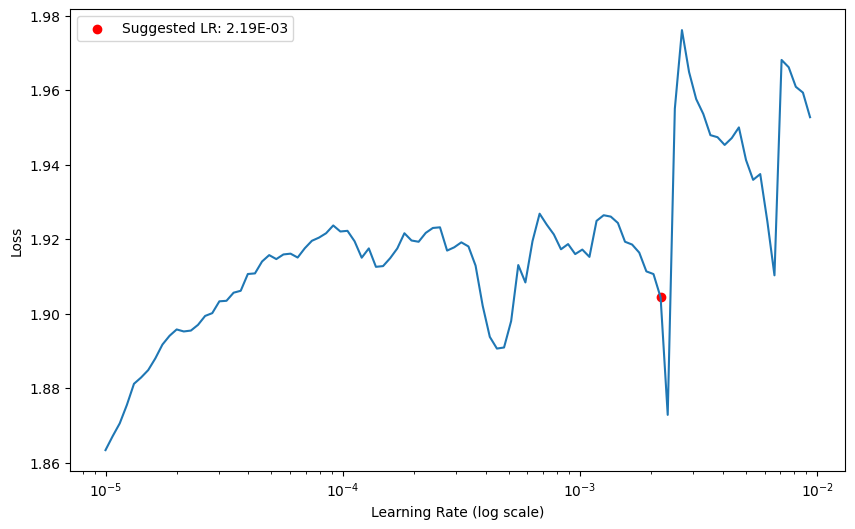

Suggested learning rate: 0.0021877616239495525


In [10]:
# Initialize model, optimizer, and dataloader
model = HomoGNN_GraphConv(128, 7)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-7)
criterion = torch.nn.CrossEntropyLoss()

# Find learning rates
lrs, losses = find_learning_rate(model, optimizer, criterion, train_loader)

# Plot results and get suggested LR
optimal_lr = plot_lr_find(lrs, losses)
print(f"Suggested learning rate: {optimal_lr}")